In [1]:
import json
import random
import tqdm
from tqdm import tqdm

import numpy as np
import pandas as pd

from rouge_score import rouge_scorer
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters


## 1. Load data

In [2]:
train = []
with open("../data/citation_generation/train.jsonl", "r") as f:
    for i, line in tqdm(enumerate(f)):
        row = json.loads(line)
        train.append(row)
        
        if i == 100: break

train = pd.DataFrame(train)
display(train.head())

100it [00:00, 8408.45it/s]


,citation_sentence,manuscript_id,cited_id,manuscript_text,cited_text
0,"Similar to earlier observations (42) , the inf...",11155963,4009171,"[, Cell membrane scrambling, a hallmark of ery...","[{'section': '', 'text': 'Plasmodium falciparu..."
1,"In a cohort study in Korea (20) , the highest ...",11158470,15153392,"[During 1,288,820 person-years of follow-up (a...","[{'section': '', 'text': 'Several previous stu..."
2,This finding can be explained by the fact that...,11159272,14840523,[Static pressure profiles are shown in Fig. 3 ...,"[{'section': '', 'text': 'A therosclerosis occ..."
3,The distribution of flow velocity and WSS was ...,11159272,13786003,[Static pressure profiles are shown in Fig. 3 ...,"[{'section': '', 'text': 'lesions therefore fa..."
4,"However, the result of CFD simulation in this ...",11159272,13786003,[Static pressure profiles are shown in Fig. 3 ...,"[{'section': '', 'text': 'lesions therefore fa..."


In [3]:
i = 0
citation_sentence = train.loc[i, "citation_sentence"]
cited_text = " ".join(para["text"] for para in train.loc[i, "cited_text"])
manuscript_text = " ".join(train.loc[i, "manuscript_text"])

print(citation_sentence)

Similar to earlier observations (42) , the infection of untreated mice with P. berghei took an invariably lethal course within Ͻ20 days.


## 2. Tokenize texts into sentences

In [4]:
# tokenizer should not split at abbrieviations
punkt_params = PunktParameters()
punkt_params.abbrev_types = set(["i.e", "e.g", "etc", "al", "fig", "figs", 
                                 "ref", "refs", "p", "c", "s"]) 

# initialise sentence tokenizer
tokenizer = PunktSentenceTokenizer(punkt_params)

In [5]:
# tokenize manuscript_result_text, cited_text into sentences
query_sentences = tokenizer.tokenize(manuscript_text)
cited_sentences = tokenizer.tokenize(cited_text)

## 3. Compute sentence embeddings

In [6]:
import sent2vec

model = sent2vec.Sent2vecModel()
model.load_model("../sent2vec/wiki_unigrams.bin")

# compute sentence embeddings
query_embeddings = model.embed_sentences(query_sentences)
cited_embeddings = model.embed_sentences(cited_sentences)

In [7]:
# from sentence_transformers import SentenceTransformer

# model = SentenceTransformer("stsb-distilbert-base")

# # compute sentence embeddings
# query_embeddings_dbert = model.encode(query_sentences)
# cited_embeddings_dbert = model.encode(cited_sentences)

## 4. Compute sentence similarity scores

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(query_embeddings, cited_embeddings)

In [9]:
k = 5

# get indices of sentences with highest similarity scores
indices = np.argpartition(similarity, kth=-k, axis=None)[-k:]

# sort indices by decreasing score and get the corresponding scores
indices = np.flip(indices[np.argsort(similarity.flatten()[indices])])
topk_similarity = similarity.flatten()[indices]
print(indices)
print(topk_similarity)

# get corresponding topk_cited_sentences
indices %= similarity.shape[1]
topk_cited_sentences = [cited_sentences[i] for i in indices]

print(citation_sentence)
print()
for s in topk_cited_sentences: print(s)

[1986 2498 2015  924 2053]
[0.67616785 0.66920614 0.6639284  0.66196144 0.6438151 ]
Similar to earlier observations (42) , the infection of untreated mice with P. berghei took an invariably lethal course within Ͻ20 days.

As illustrated in Fig. 1B (middle and right) osmotic cell shrinkage inhibited and osmotic cell swelling activated a fraction of the whole cell inward current.
Initial cell swelling in hypotonic sorbitol solution and hyperpolarization of the cation-selective cell membrane are expected to activate putative ClC-2 channels.
Initial cell swelling in hypotonic sorbitol solution and hyperpolarization of the cation-selective cell membrane are expected to activate putative ClC-2 channels.
In further experiments, the effect of ClC-2 inhibition on forward scatter was determined in noninfected and parasitized RBCs from both genotypes.
Thus inhibition of ClC-2 increased cell volume only in parasitized RBCs.


In [10]:
# compute ROUGE scores
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

scores = scorer.score(citation_sentence, " ".join(topk_cited_sentences))
scores = pd.DataFrame(scores).T
scores.columns = ["p", "r", "f"]
display(scores)

,p,r,f
rouge1,0.028571,0.142857,0.047619
rouge2,0.000000,0.000000,0.000000
rougeL,0.028571,0.142857,0.047619


In [11]:
def get_topk_citation_sentences(manuscript_text, cited_text, k=5):
    # tokenize into sentences
    query_sentences = tokenizer.tokenize(manuscript_text)
    cited_sentences = tokenizer.tokenize(cited_text)

    # compute embeddings and cosine similarity matrix
    query_embeddings = model.embed_sentences(query_sentences)
    cited_embeddings = model.embed_sentences(cited_sentences)
    similarity = cosine_similarity(query_embeddings, cited_embeddings)
    
    # get indices of highest similarity scores 
    indices = np.argpartition(similarity, kth=-k, axis=None)[-k:]
    
    # get indices in decreasing order wrt scores
    indices = np.flip(indices[np.argsort(similarity.flatten()[indices])])
    
    # get corresponding sentences  
    indices %= similarity.shape[1]
    topk_cited_sentences = [cited_sentences[i] for i in indices]

    return topk_cited_sentences

## 5. Extractively summarize the small train set

In [12]:
all_topk_cited_sentences = []
for _, row in train.iterrows():
    topk_citation_sentences = get_topk_citation_sentences(
        " ".join(row.manuscript_text), " ".join(para["text"] for para in row.cited_text)
    )
    all_topk_cited_sentences.append(topk_citation_sentences)
print(all_topk_cited_sentences[0])

['As illustrated in Fig. 1B (middle and right) osmotic cell shrinkage inhibited and osmotic cell swelling activated a fraction of the whole cell inward current.', 'Initial cell swelling in hypotonic sorbitol solution and hyperpolarization of the cation-selective cell membrane are expected to activate putative ClC-2 channels.', 'Initial cell swelling in hypotonic sorbitol solution and hyperpolarization of the cation-selective cell membrane are expected to activate putative ClC-2 channels.', 'In further experiments, the effect of ClC-2 inhibition on forward scatter was determined in noninfected and parasitized RBCs from both genotypes.', 'Thus inhibition of ClC-2 increased cell volume only in parasitized RBCs.']


In [13]:
train["topk_cited_sentences"] = all_topk_cited_sentences
display(train.head())

,citation_sentence,manuscript_id,cited_id,manuscript_text,cited_text,topk_cited_sentences
0,"Similar to earlier observations (42) , the inf...",11155963,4009171,"[, Cell membrane scrambling, a hallmark of ery...","[{'section': '', 'text': 'Plasmodium falciparu...",[As illustrated in Fig. 1B (middle and right) ...
1,"In a cohort study in Korea (20) , the highest ...",11158470,15153392,"[During 1,288,820 person-years of follow-up (a...","[{'section': '', 'text': 'Several previous stu...","[In both men and women, the taller group tende..."
2,This finding can be explained by the fact that...,11159272,14840523,[Static pressure profiles are shown in Fig. 3 ...,"[{'section': '', 'text': 'A therosclerosis occ...",[The proximal and distal MB was considered as ...
3,The distribution of flow velocity and WSS was ...,11159272,13786003,[Static pressure profiles are shown in Fig. 3 ...,"[{'section': '', 'text': 'lesions therefore fa...",[Blood was assumed to behave as a Newtonian fl...
4,"However, the result of CFD simulation in this ...",11159272,13786003,[Static pressure profiles are shown in Fig. 3 ...,"[{'section': '', 'text': 'lesions therefore fa...",[Blood was assumed to behave as a Newtonian fl...


In [14]:
rouge = {"rouge1": [], "rouge2": [], "rougeL": []}
for _, row in train.iterrows():
    scores = scorer.score(row.citation_sentence, " ".join(row.topk_cited_sentences))
    for k in scores: 
        rouge[k].append(scores[k][1]) # to extract only recall score
        
rouge = pd.DataFrame(rouge)
display(rouge)

,rouge1,rouge2,rougeL
0,0.142857,0.000000,0.142857
1,0.558824,0.090909,0.323529
2,0.190476,0.024390,0.095238
3,0.538462,0.000000,0.461538
4,0.421053,0.000000,0.263158
...,...,...,...
96,0.250000,0.000000,0.200000
97,0.490566,0.019231,0.226415
98,0.333333,0.086957,0.250000
99,0.230769,0.000000,0.153846


In [15]:
for k in rouge.columns: train[k] = rouge[k]
display(train.head())

,citation_sentence,manuscript_id,cited_id,manuscript_text,cited_text,topk_cited_sentences,rouge1,rouge2,rougeL
0,"Similar to earlier observations (42) , the inf...",11155963,4009171,"[, Cell membrane scrambling, a hallmark of ery...","[{'section': '', 'text': 'Plasmodium falciparu...",[As illustrated in Fig. 1B (middle and right) ...,0.142857,0.000000,0.142857
1,"In a cohort study in Korea (20) , the highest ...",11158470,15153392,"[During 1,288,820 person-years of follow-up (a...","[{'section': '', 'text': 'Several previous stu...","[In both men and women, the taller group tende...",0.558824,0.090909,0.323529
2,This finding can be explained by the fact that...,11159272,14840523,[Static pressure profiles are shown in Fig. 3 ...,"[{'section': '', 'text': 'A therosclerosis occ...",[The proximal and distal MB was considered as ...,0.190476,0.024390,0.095238
3,The distribution of flow velocity and WSS was ...,11159272,13786003,[Static pressure profiles are shown in Fig. 3 ...,"[{'section': '', 'text': 'lesions therefore fa...",[Blood was assumed to behave as a Newtonian fl...,0.538462,0.000000,0.461538
4,"However, the result of CFD simulation in this ...",11159272,13786003,[Static pressure profiles are shown in Fig. 3 ...,"[{'section': '', 'text': 'lesions therefore fa...",[Blood was assumed to behave as a Newtonian fl...,0.421053,0.000000,0.263158


<AxesSubplot:>

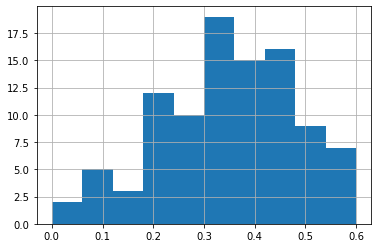

In [20]:
display(train["rouge1"].hist(range=(0,0.6)))

<AxesSubplot:>

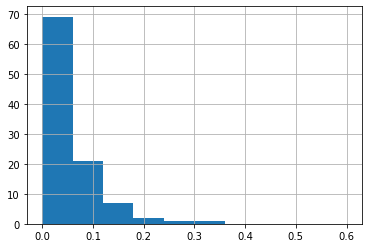

In [21]:
display(train["rouge2"].hist(range=(0,0.6)))

<AxesSubplot:>

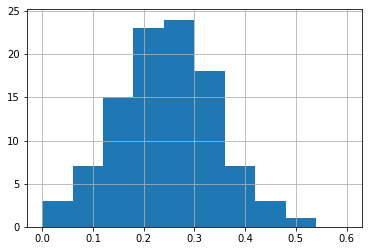

In [22]:
display(train["rougeL"].hist(range=(0,0.6)))

In [23]:
ind = train.rouge1.argmax()
row = train.loc[ind]
print(row["rouge1"])
print(row["citation_sentence"])
print()
for s in row["topk_cited_sentences"]: print(s)

0.6551724137931034
In a previous study, we did not Wnd an association between F-ara-ATP accumulation and gene expression in CD4 + and CD8 + T-lymphocytes isolated from HCT patients [15] .

These replicates were within 71-100% of each other.
Median cell yields after T-lymphocyte isolation in healthy volunteers were 2.98 9 10 7 and 2.67 9 10 7 for CD4 + and CD8 + cells, respectively.
Median cell yields after T-lymphocyte isolation in HCT patients were 3.78 9 10 6 and 2.
Less variability was observed in the expression of hENT2, dCK, and CN-II.
F-ara-ATP accumulation was linear over a starting cell number from 1.25 9 10 5 to 2 9 10 6 cells (data not shown).


## 6. Convert to scr

In [ ]:
# import time

# from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters

# import sent2vec
# from sklearn.metrics.pairwise import cosine_similarity

# # initialise sentence tokenizer
# # tokenizer should not split at abbrieviations
# punkt_params = PunktParameters()
# punkt_params.abbrev_types = set(["i.e", "e.g", "etc", "al", "fig", "figs", 
#                                  "ref", "refs", "p", "c", "s"]) 
# tokenizer = PunktSentenceTokenizer(punkt_params)

# # initialise sentence embedding model 
# model = sent2vec.Sent2vecModel()
# model.load_model("../sent2vec/wiki_unigrams.bin")
    

# time_taken = []
# all_topk_scores = []
# all_topk_cited_sentences = []
# all_rouge = {i:[] for i in range(5)}
# with open("../data/citation_generation/unique_dataset.jsonl", "r") as f:
#     for line in tqdm(f):
#         start = time.time()
#         row = json.loads(line)
        
#         # extract data from row
#         citation_sentence = row["citation_sentence"]
#         manuscript_result_text = row["manuscript_result_text"]
#         cited_text = row["cited_text"]
        
#         # tokenize manuscript_result_text, cited_text into sentences
#         query_sentences = tokenizer.tokenize(manuscript_result_text)
#         cited_sentences = tokenizer.tokenize(cited_text)
        
#         # compute sentence embeddings
#         query_embeddings = model.embed_sentences(query_sentences)
#         cited_embeddings = model.embed_sentences(cited_sentences)
        
#         # compute similarity matrix
#         similarity = cosine_similarity(query_embeddings, cited_embeddings)
        
#         # get indices of highest similarity scores 
#         indices = np.argpartition(similarity, kth=-k, axis=None)[-k:]

#         # get indices in decreasing order wrt scores and corresponding scores 
#         indices = np.flip(indices[np.argsort(similarity.flatten()[indices])])
#         topk_scores = similarity.flatten()[indices]
#         all_topk_scores.append(topk_scores)
        
#         # get corresponding cited_sentences 
#         indices %= similarity.shape[1]
#         topk_cited_sentences = [cited_sentences[i] for i in indices]
#         all_topk_cited_sentences.append(topk_cited_sentences)

#         # record rouge scores
#         for i in range(1,5):
#             all_rouge[i].append(rouge_n(citation_sentence, " ".join(topk_cited_sentences), n=i))
        
#         # record time taken for this row
#         time_taken.append(time.time() - start)
#         break